### Demo to do the max-T permutation.
When we do permutation test, a null distribution is created by randomly resampling all data points into 2 variables. However, the type I error may inflate especially when we need to do multiple comparisons in our data set (i.e., voxel-wise analysis in fMRI). Thus, it would be necessary to conduct a multiple comparison correction to control the family wise error rate (false-positive). Here I provide a demo to use max-T method to create a null distribution with the maximum variable statistic of each iteration. The steps are listed as following:

1. put all data into a pool
2. randomly resample data into different variables
3. calculate the mean differences between variables for all combinations, and take the maximum mean*
4. iterate the 1-3 steps
5. compare the original mean to the max null distribution to calculate the p-value

*: The statistic measurement can be mean or median or any other methods you want

In [6]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# t-max method for permutation test
def null_dist_max(my_dict, iteration=10000, mode="greater", visual = False, axes = None):
    """
    function to create maximum null distribution
    Paramters:
    -----------------
        my_dict: dict
            A dict data with variables. For instance, {"A":list, "B":list, "C":list}
        iteration: int
            how many times to shuffle
        mode: str
            alternative of the comparison
        visual: boolen
            create plot or not
        axes:
            used for creating multiple plots
    Returns:
    ------------------
        output_df:dataframe
            the p-value and original mean for all the possible comparisons.
    
    """
    it = 0
    dist_null = []
    keys = list(my_dict.keys())
    var_num = len(my_dict)
    total_number_var = []

    # create pool
    pool_real = []
    for i in range(var_num):
        tmp = len(my_dict[list(my_dict.keys())[i]])
        total_number_var.append(tmp)
        pool_real = np.hstack((pool_real,my_dict[list(my_dict.keys())[i]]))
    
    # combination set
    comba = list(itertools.combinations(range(var_num), 2))
    # give labels to comba
    comba_with_name = []
    for x in comba:
        tmp_one = (keys[x[0]], keys[x[1]])
        comba_with_name.append(tmp_one)

    # iterative process
    while it < iteration:
        fake_dict = {}
        pool_fake = [*range(len(pool_real))]
        for i in range(var_num):
            fake_dict[keys[i]] = np.random.choice(pool_fake, size= total_number_var[i], replace=False)
            pool_fake = np.asarray([ele for ele in pool_fake if ele not in fake_dict[keys[i]]])

        shuffle_dict = {}
        for i in range(var_num):
            shuffle_dict[keys[i]] = pool_real[fake_dict[keys[i]]]

        mean_across_var = []
        for i in comba_with_name:
            mean_diff = np.mean(shuffle_dict[i[0]]) - np.mean(shuffle_dict[i[1]])
            mean_across_var.append(mean_diff)
        p_max = max(mean_across_var)
        dist_null.append(p_max)
        it += 1
    
    # compute the original mean
    output_df = pd.DataFrame()
    for i in comba_with_name:
        mean_diff = np.mean(my_dict[i[0]]) - np.mean(my_dict[i[1]])
        if mode in ["greater"]:
            p_v = (np.array(dist_null)[dist_null > mean_diff].shape[0] + 1) / (iteration + 1)
            a_dict = {"From":i[0], "To": i[1], "p_value": p_v, "origin_mean": mean_diff}
        elif mode in ["less"]:
            p_v = (np.array(dist_null)[dist_null < mean_diff].shape[0] + 1) / (iteration + 1)
            a_dict = {"From":i[0], "To": i[1], "p_value": p_v, "origin_mean": mean_diff}
        else:
            raise ValueError(f"please enter valid mode names, i.e., greater, less ")
        output_df = pd.concat([output_df, pd.DataFrame.from_dict([a_dict])], ignore_index=True)
    if visual:
        if axes is None:
            fig = plt.figure(figsize=(7,7),dpi=300)
            axes = fig.add_subplot(111)
        sns.histplot(data=dist_null, bins='auto', ax=axes)
        #plt.axvline(x=np.round(permu_mean,3), label='Permutation Mean at {}'.format(np.round(permu_mean,3)),c='g')
        for i in range(len(comba)):
            axes.axvline(x=output_df["origin_mean"][i], linestyle = 'dashed', c = np.random.rand(3,), label = f'{output_df["From"][i]} to {output_df["To"][i]}')
            print(f'statistic between {output_df["From"][i]} and {output_df["To"][i]} at {np.round(output_df["origin_mean"][i],3)}, with p-value {np.round(output_df["p_value"][i],3)}')
        plt.legend()
        plt.show()

    return output_df

statistic between A and B at 15.347, with p-value 0.27
statistic between A and C at 51.353, with p-value 0.0
statistic between A and D at 58.287, with p-value 0.0
statistic between B and C at 36.006, with p-value 0.002
statistic between B and D at 42.939, with p-value 0.0
statistic between C and D at 6.933, with p-value 0.71


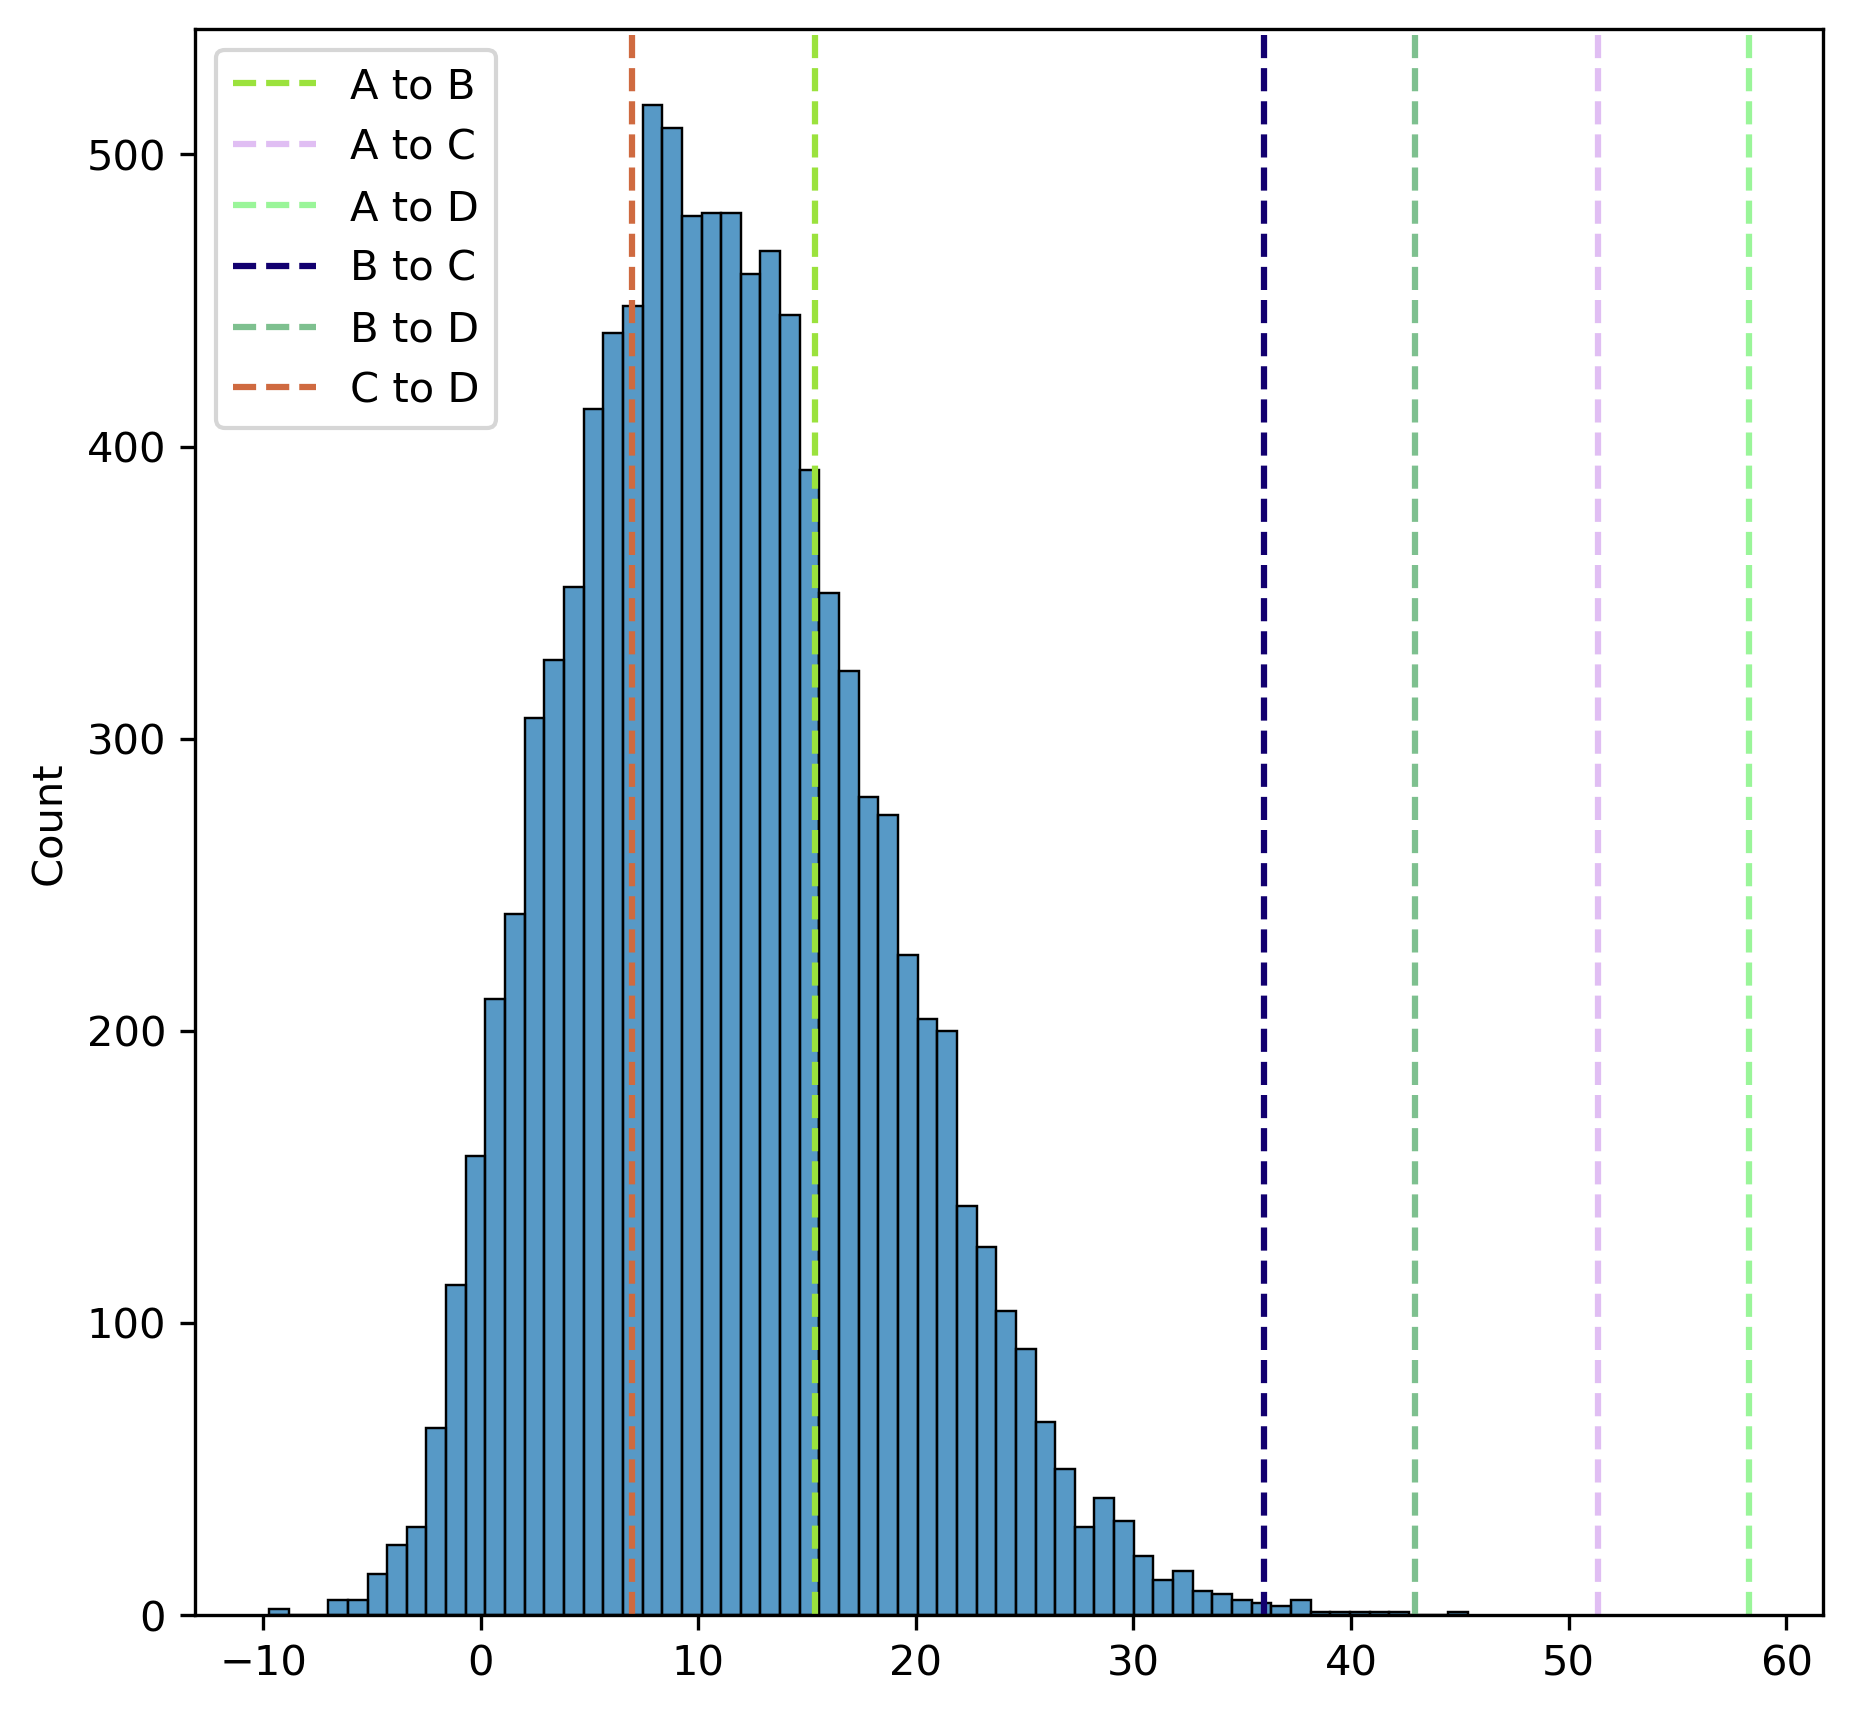

,From,To,p_value,origin_mean
0,A,B,0.270373,15.347273
1,A,C,0.000100,51.353333
2,A,D,0.000100,58.286667
3,B,C,0.001800,36.006061
4,B,D,0.000200,42.939394
5,C,D,0.709529,6.933333


In [7]:
randict = {"A":np.random.randint(200, size=50), "B":np.random.randint(200, size=55), "C":np.random.randint(100,size=45), "D":np.random.randint(100,size=60)}
null_dist_max(randict, iteration=10000, mode="greater", visual = True)